In [35]:
%%capture
!pip install -q kagglehub torch torchvision scikit-learn pandas opencv-python tqdm scikit-multilearn matplotlib seaborn

In [36]:

import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import kagglehub
import seaborn as sns
import matplotlib.pyplot as plt
from skmultilearn.model_selection import iterative_train_test_split

## Download Dataset 

In [37]:
# 1. Download Dataset (Official ODIR-5K)
path = kagglehub.dataset_download("andrewmvd/ocular-disease-recognition-odir5k")
print("Dataset path:", path)
IMG_DIR = os.path.join(path, "ODIR-5K/ODIR-5K/Training Images")
CSV_PATH = os.path.join(path, "full_df.csv")
df = pd.read_csv(CSV_PATH)
df.head()

Dataset path: /home/ray/.cache/kagglehub/datasets/andrewmvd/ocular-disease-recognition-odir5k/versions/2


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


## Explore Data Set

This section includes codes from https://www.kaggle.com/code/fridahnjunge/densenet121final

In [38]:
print(f" This dataset has {df.shape[0]} observations and {df.shape[1]} variables")

 This dataset has 6392 observations and 19 variables


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [40]:
null_values_count=df.isna().sum()
duplicates_count=df.duplicated().sum()
print("Null values count:")
print(null_values_count)
print("Duplicates count:", duplicates_count)
print("Duplicated ID count:", df['ID'].duplicated().sum())

Null values count:
ID                           0
Patient Age                  0
Patient Sex                  0
Left-Fundus                  0
Right-Fundus                 0
Left-Diagnostic Keywords     0
Right-Diagnostic Keywords    0
N                            0
D                            0
G                            0
C                            0
A                            0
H                            0
M                            0
O                            0
filepath                     0
labels                       0
target                       0
filename                     0
dtype: int64
Duplicates count: 0
Duplicated ID count: 3034


We realise that our data contains more than 1 rows for each patient ID

In [41]:
df[df.duplicated(subset=['ID'], keep=False)].sort_values(by='ID').head(6)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
3194,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",0_left.jpg
3195,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_left.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
3197,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",4_left.jpg


For Dual Eyes approach or Binocular,  we can remove few columns:
- Patient Age
- Patient Sex
- Left-Diagnostic
- Right-Diagnostic
- filepath
- Labels
- Target
- Filename

In [42]:
df2 = df.drop(['filename', 'target', 'labels','filepath', 'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords'], axis=1, inplace=False)
df2.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,0,1,0,0,0,0,0,1
3,4,53,Male,4_left.jpg,4_right.jpg,0,1,0,0,0,0,0,1
4,5,50,Female,5_left.jpg,5_right.jpg,0,1,0,0,0,0,0,0


In [43]:
df2.duplicated().sum()

np.int64(3034)

In [44]:
df2.drop_duplicates(inplace=True)
df2.duplicated().sum()

np.int64(0)

multiple
1    2802
2     529
3      27
Name: count, dtype: int64


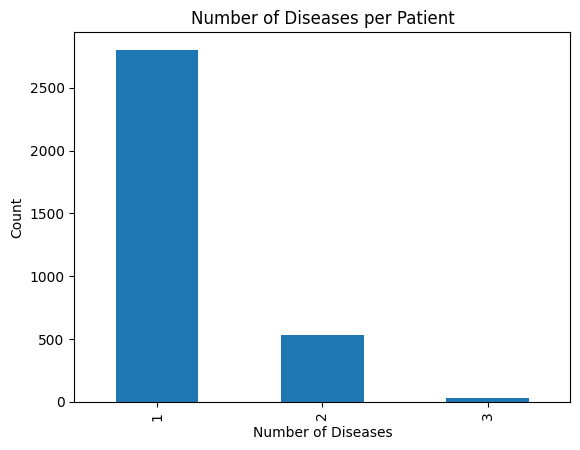

In [45]:
df2['multiple']=df2[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum(axis=1)
counts= df2['multiple'].value_counts()
print(counts)
counts.plot(kind='bar')
plt.title('Number of Diseases per Patient')
plt.xlabel('Number of Diseases')
plt.ylabel('Count')
plt.show()

We can see that 529  has 2 labels, 27 has 3 labels and 2802 patient has unique 1 label


--- Univariate: Patient Age ---
count    3358.000000
mean       57.889815
std        11.730862
min         1.000000
25%        51.000000
50%        59.000000
75%        66.000000
max        91.000000
Name: Patient Age, dtype: float64


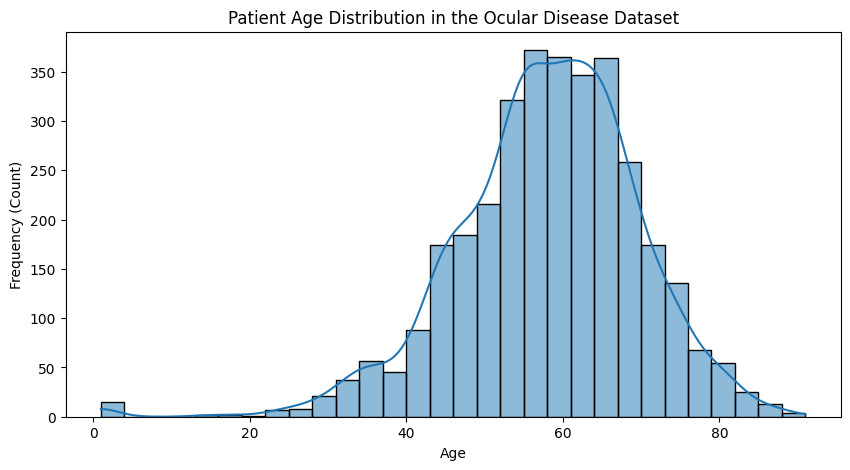

In [46]:
# --- Patient Age ---
print("\n--- Univariate: Patient Age ---")
print(df2['Patient Age'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df2['Patient Age'], kde=True, bins=30)
plt.title('Patient Age Distribution in the Ocular Disease Dataset')
plt.xlabel('Age')
plt.ylabel('Frequency (Count)')
plt.show()


--- Univariate: Patient Sex ---
Patient Sex
Male      0.536033
Female    0.463967
Name: proportion, dtype: float64


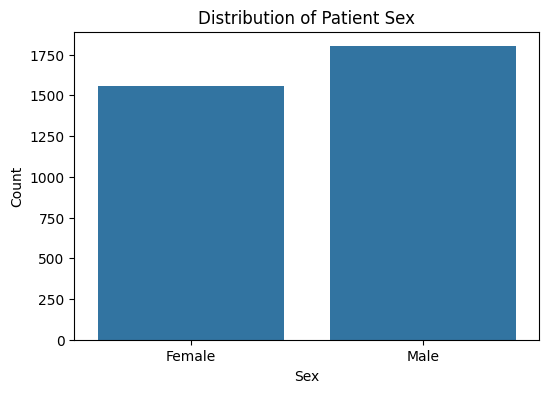

In [47]:
# --- Patient Sex ---
print("\n--- Univariate: Patient Sex ---")
print(df2['Patient Sex'].value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x='Patient Sex', data=df2)
plt.title('Distribution of Patient Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()


--- Univariate: Target Label (Disease) Distribution ---
D    1105
N    1080
O     905
C     208
G     206
M     171
A     163
H     103
dtype: int64


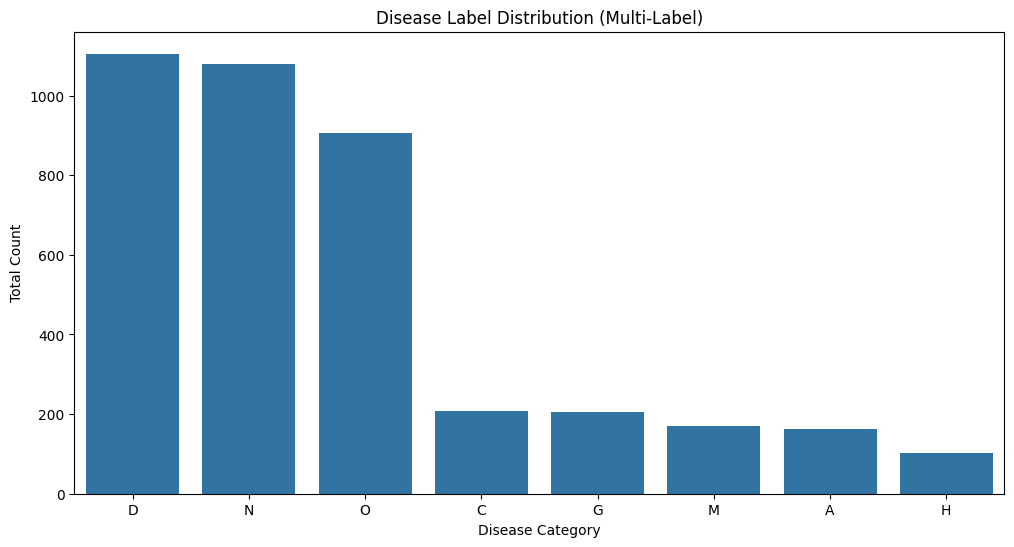

In [48]:
# --- Target Labels (Diseases) ---
print("\n--- Univariate: Target Label (Disease) Distribution ---")
# N=Normal, D=Diabetes, G=Glaucoma, C=Cataract, A=AMD, H=Hypertension, M=Myopia, O=Other
Ohe_cols = df2[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']]

disease_counts = Ohe_cols.sum().sort_values(ascending=False)
print(disease_counts)

plt.figure(figsize=(12, 6))
sns.barplot(x=disease_counts.index, y=disease_counts.values)
plt.title('Disease Label Distribution (Multi-Label)')
plt.xlabel('Disease Category')
plt.ylabel('Total Count')
plt.show()


--- Multivariate: Disease Co-occurrence Heatmap ---


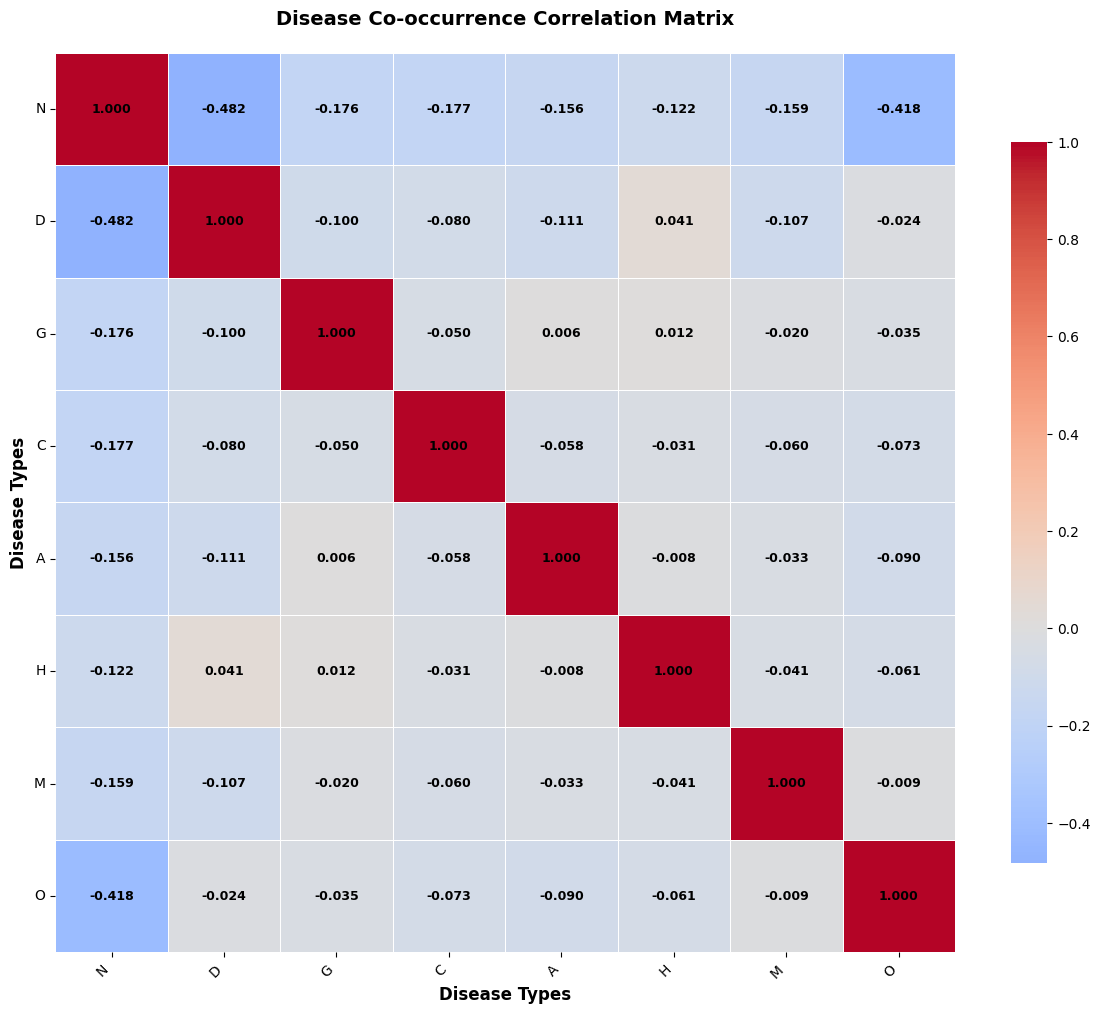

In [49]:
# --- Disease Co-occurrence ---
print("\n--- Multivariate: Disease Co-occurrence Heatmap ---")

correlation_matrix = Ohe_cols.corr()

fig, ax = plt.subplots(figsize=(12, 10))

# Create heatmap without annotations first
heatmap = sns.heatmap(
    correlation_matrix, 
    annot=False,  
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'shrink': 0.8},
    ax=ax
)
# Manually add annotations to every cell
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        text = ax.text(j + 0.5, i + 0.5, f'{correlation_matrix.iloc[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=9, weight='bold')

plt.title('Disease Co-occurrence Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Disease Types', fontsize=12, fontweight='bold')
plt.ylabel('Disease Types', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

We can see from our correlation matrix that Hypertension sometimes occur together with either Diabetes or Glaucoma.

In [50]:
y = df2[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']] # we will use the individual disease labels for modeling
X = df2.drop(['multiple', 'ID', 'Patient Age', 'Patient Sex', 'N', 'D', 'G', 'C', 'A', 'H', 'M', 'O'], axis=1) 
# we do not need the ID, Patient Age or Sex for modeling, and 'multiple' is derived from the target labels
print("Feature columns:", X.columns.tolist())
print("Target columns:", y.columns.tolist())
print("Rows count X:", len(X))
print("Rows count y:", len(y))
X.head()


Feature columns: ['Left-Fundus', 'Right-Fundus']
Target columns: ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
Rows count X: 3358
Rows count y: 3358


,Left-Fundus,Right-Fundus
0,0_left.jpg,0_right.jpg
1,1_left.jpg,1_right.jpg
2,2_left.jpg,2_right.jpg
3,4_left.jpg,4_right.jpg
4,5_left.jpg,5_right.jpg


In [51]:
y.head()

,N,D,G,C,A,H,M,O
0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0


# Split train vs validation

In [52]:
import pandas as pd
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split
def iterative_train_test_split_dataframe(X, y, test_size):
    noob_train_test_split = iterative_train_test_split
    X_train, y_train, X_test, y_test = noob_train_test_split(X.reset_index().to_numpy(), y.to_numpy(), test_size=test_size)

    df_X_train = pd.DataFrame(X_train[:, 1:], columns=X.columns, index=X_train[:, 0])
    df_y_train = pd.DataFrame(y_train, columns=y.columns, index=df_X_train.index)
    df_X_test = pd.DataFrame(X_test[:, 1:], columns=X.columns, index=X_test[:, 0])
    df_y_test = pd.DataFrame(y_test, columns=y.columns, index=df_X_test.index)
    return df_X_train, df_y_train, df_X_test, df_y_test

In [53]:
X_train, y_train, X_val, y_val = iterative_train_test_split_dataframe(X, y, test_size=0.2)
train_df = pd.concat([X_train, y_train], axis=1)
X_val, y_val, X_test, y_test = iterative_train_test_split_dataframe(X_val, y_val, test_size=0.5)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)
print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))
print("Test samples:", len(test_df))

Training samples: 2690
Validation samples: 336
Test samples: 332
